In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

c:\Users\Rainy\.conda\envs\pytorch-onnx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


读取数据

In [2]:
df = pd.read_excel('PCA-result.xlsx', header=None)
df

,0,1,2
0,-1.747483,0.000169,0
1,-2.057982,-0.031358,0
2,-2.057702,-0.134579,0
3,-2.057853,0.032013,0
4,-2.057996,0.134560,0
...,...,...,...
85,26.072852,0.002549,8
86,6.865076,-2.269084,8
87,6.862145,-10.216394,8
88,6.845561,2.267776,8


In [3]:
df.describe()

,0,1,2
count,9.000000e+01,9.000000e+01,90.000000
mean,-2.565849e-16,-9.868649e-17,4.000000
std,4.569095e+00,2.134043e+00,2.596454
min,-2.057996e+00,-1.021639e+01,0.000000
25%,-1.883187e+00,-2.321715e-01,2.000000
50%,-1.477582e+00,2.479751e-04,4.000000
75%,-6.076416e-01,2.322346e-01,6.000000
max,2.614912e+01,1.021755e+01,8.000000


In [4]:
df.corr()

,0,1,2
0,1.000000,0.000000,0.542279
1,0.000000,1.000000,-0.000066
2,0.542279,-0.000066,1.000000


In [5]:
train_data = df.iloc[:, :2].values  
train_labels = df.iloc[:, 2].values 

train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)

In [6]:
train_data

tensor([[-1.7475e+00,  1.6939e-04],
        [-2.0580e+00, -3.1358e-02],
        [-2.0577e+00, -1.3458e-01],
        [-2.0579e+00,  3.2013e-02],
        [-2.0580e+00,  1.3456e-01],
        [-1.7469e+00,  3.2656e-04],
        [-2.0281e+00, -3.4247e-02],
        [-2.0277e+00, -1.4918e-01],
        [-2.0276e+00,  3.4006e-02],
        [-2.0275e+00,  1.4943e-01],
        [-1.4072e+00,  1.3437e-04],
        [-1.9769e+00, -5.6539e-02],
        [-1.9766e+00, -2.4224e-01],
        [-1.9768e+00,  5.7178e-02],
        [-1.9769e+00,  2.4217e-01],
        [-1.4074e+00,  3.3052e-04],
        [-1.9194e+00, -6.1716e-02],
        [-1.9191e+00, -2.7203e-01],
        [-1.9192e+00,  6.1445e-02],
        [-1.9188e+00,  2.7228e-01],
        [-1.2949e+00,  1.2280e-04],
        [-1.9505e+00, -6.4730e-02],
        [-1.9503e+00, -2.7738e-01],
        [-1.9505e+00,  6.5363e-02],
        [-1.9506e+00,  2.7730e-01],
        [-1.2953e+00,  3.3295e-04],
        [-1.8835e+00, -7.0770e-02],
        [-1.8833e+00, -3.125

In [7]:
train_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

**搭建模型**

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.fc4 = nn.Linear(hidden_size, hidden_size)
#         self.fc5 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.fc3(out)
#         out = self.relu(out)
#         out = self.fc4(out)
#         out = self.relu(out)
#         out = self.fc5(out)
#         return out

input_size = 2  # 输入特征
hidden_size = 200 
num_classes = 9  # 输出类别

learning_rate = 0.001  # 学习率
num_epochs = 500  # 训练轮数

模型训练

In [9]:
model = NeuralNetwork(input_size, hidden_size, num_classes)

In [10]:
model

NeuralNetwork(
  (fc1): Linear(in_features=2, out_features=200, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=200, out_features=9, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_history = []

total_steps = len(train_data)
for epoch in range(num_epochs):
    for i in range(total_steps):
        x = train_data[i].unsqueeze(0) 
        labels = train_labels[i].unsqueeze(0)

        outputs = model(x)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_history.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item()}')

Epoch [1/500], Step [90/90], Loss: 0.047312308102846146
Epoch [2/500], Step [90/90], Loss: 0.02941015735268593
Epoch [3/500], Step [90/90], Loss: 0.026808204129338264
Epoch [4/500], Step [90/90], Loss: 0.0291694737970829
Epoch [5/500], Step [90/90], Loss: 0.03092065267264843
Epoch [6/500], Step [90/90], Loss: 0.030880890786647797
Epoch [7/500], Step [90/90], Loss: 0.030001023784279823
Epoch [8/500], Step [90/90], Loss: 0.02889653854072094
Epoch [9/500], Step [90/90], Loss: 0.027778657153248787
Epoch [10/500], Step [90/90], Loss: 0.026706187054514885
Epoch [11/500], Step [90/90], Loss: 0.025690658017992973
Epoch [12/500], Step [90/90], Loss: 0.02472817711532116
Epoch [13/500], Step [90/90], Loss: 0.023816918954253197
Epoch [14/500], Step [90/90], Loss: 0.022953180596232414
Epoch [15/500], Step [90/90], Loss: 0.022133586928248405
Epoch [16/500], Step [90/90], Loss: 0.02135533094406128
Epoch [17/500], Step [90/90], Loss: 0.020615121349692345
Epoch [18/500], Step [90/90], Loss: 0.019911877

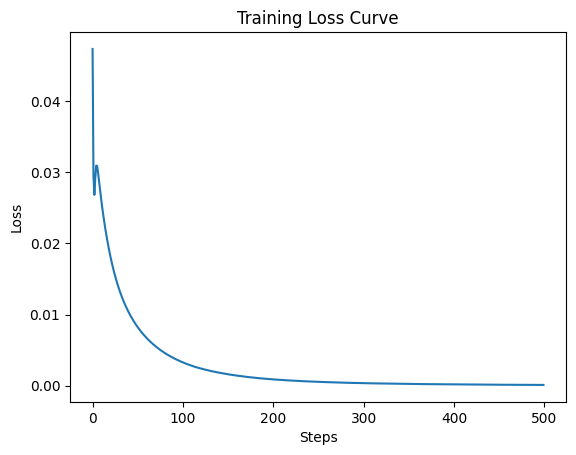

In [12]:
plt.plot(loss_history)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

保存模型参数

In [14]:
torch.save(model.state_dict(), 'bp_8class_pca.params')

加载和测试模型

In [15]:
data_test = pd.read_excel("test_label.xlsx", header=None)
test_x = np.array(data_test.iloc[:, 0:2])
test_y = np.array(data_test.iloc[:, 2])
test_data = torch.tensor(test_x, dtype=torch.float32)
test_labels = torch.tensor(test_y, dtype=torch.long)

# 评估模式
clone = NeuralNetwork(input_size, hidden_size, num_classes)
clone.load_state_dict(torch.load('bp_8class_pca.params'))
clone.eval()
with torch.no_grad():
    # 预测测试数据
    outputs = clone(test_data)
    _, predicted = torch.max(outputs.data, 1)
    for i in range(len(test_data)):
        print(f"Predicted: {predicted[i]}, Actual: {test_labels[i]}")

    # 计算准确率
    correct = (predicted == test_labels).sum().item()
    total = len(test_data)
    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100}%")

Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 7, Actual: 1
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 8, Actual: 0
Predicted: 7, Actual: 2
Predicted: 7, Actual: 0
Predicted: 7, Actual: 0
Predicted: 8, Actual: 3
Predicted: 7, Actual: 8
Predicted: 7, Actual: 1
Predicted: 8, Actual: 0
Accuracy: 0.0%


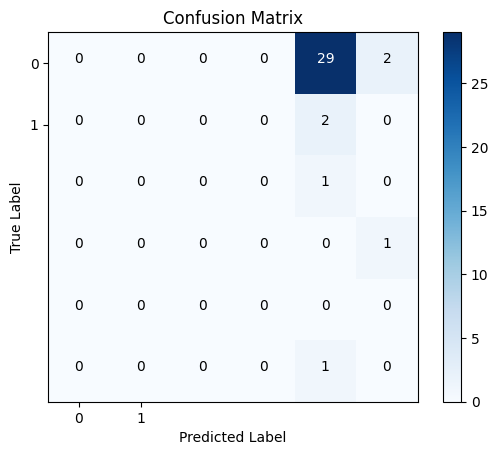

In [17]:
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(test_labels, predicted)

plt.imshow(cm, cmap='Blues')
plt.colorbar()
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [18]:
import numpy as np
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# 计算分类报告
report = classification_report(test_labels, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      31.0
           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       1.0

    accuracy                           0.00      36.0
   macro avg       0.00      0.00      0.00      36.0
weighted avg       0.00      0.00      0.00      36.0

